# **TikTok Project**

The team has requested to build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

# **Classify videos using machine learning**

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**


<img src="images/Plan.png" width="100" height="100" align=left>


## **PACE: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:

**1. What are you being asked to do?**

**Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. 

For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable.

**Select an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim

**2. What are the ethical implications of building the model?**
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

**3. How would you proceed?**

**Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [50]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, classification_report


# Import packages for data modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle
import shap
shap.initjs()


In [51]:
# Load dataset into dataframe
data = pd.read_csv("TikTokDataset.csv")

<img src="images/Analyze.png" width="100" height="100" align=left>

## **PACE: Analyze**

Consider the questions in your PACE Strategy Document to reflect on the Analyze stage.

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [52]:
# Display first few rows
data.head()

,s_no,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [53]:
# Get number of rows and columns
data.shape


(19382, 12)

Get the data types of the columns.

In [54]:
# Get data types of columns
data.dtypes


s_no                          int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

Get basic information about the dataset.

In [55]:
# Get basic information
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   s_no                      19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [56]:
# Generate basic descriptive stats
data.describe(include='all')


,s_no,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,19084,1.938200e+04,19382.000000,19084,19382,19382,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
unique,NaN,2,NaN,NaN,19012,2,3,NaN,NaN,NaN,NaN,NaN
top,NaN,claim,NaN,NaN,a friend read in the media a claim that badmi...,not verified,active,NaN,NaN,NaN,NaN,NaN
freq,NaN,9608,NaN,NaN,2,18142,15663,NaN,NaN,NaN,NaN,NaN
mean,9691.500000,NaN,5.627454e+09,32.421732,NaN,NaN,NaN,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,NaN,2.536440e+09,16.229967,NaN,NaN,NaN,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,NaN,1.234959e+09,5.000000,NaN,NaN,NaN,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,NaN,3.430417e+09,18.000000,NaN,NaN,NaN,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,NaN,5.618664e+09,32.000000,NaN,NaN,NaN,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,NaN,7.843960e+09,47.000000,NaN,NaN,NaN,504327.000000,125020.000000,18222.000000,1156.250000,292.000000


Check for and handle missing values.

In [57]:
# Check for missing values
data.isna().sum(axis=0)


s_no                          0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [58]:
# Drop rows with missing values
data = data.dropna(axis=0)
data.isna().sum(axis=0)


s_no                        0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64

In [59]:
# Display first few rows after handling missing values
data.head()


,s_no,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Check for and handle duplicates.

In [60]:
# Check for duplicates
data.duplicated().sum(axis=0)

0

Check for and handle outliers.

Tree based models are robust to outliers

Check class balance.

In [61]:
# Check class balance
data['claim_status'].value_counts(' ')


claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

<img src="images/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [62]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data['text_length'] = data['video_transcription_text'].apply(func = len)
data.head()

,s_no,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [63]:
# Calculate the average text_length for claims and opinions
data.groupby('claim_status')[['text_length']].mean()


,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions.

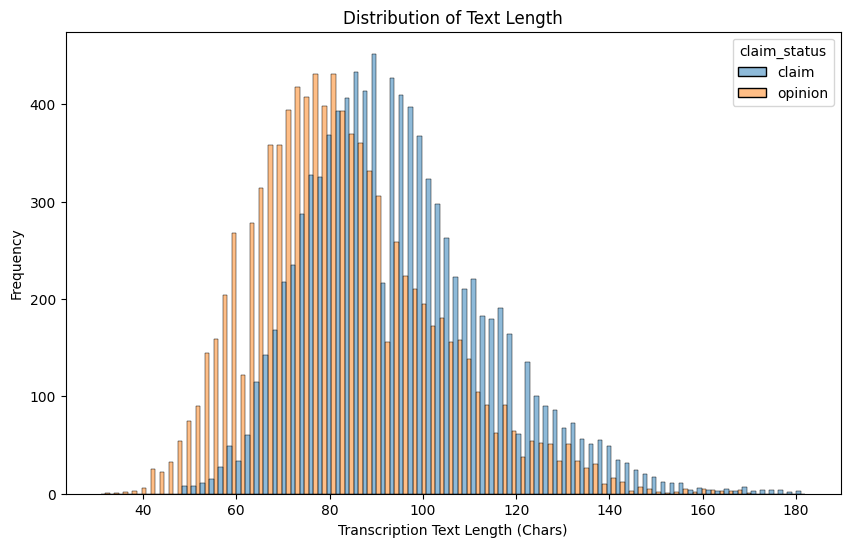

In [64]:
# Visualize the distribution of `text_length` for claims and opinions

plt.figure(figsize=(10,6))
sns.histplot(data=data, x='text_length', hue='claim_status', multiple='dodge', alpha=0.5)
plt.title('Distribution of Text Length')
plt.ylabel('Frequency')
plt.xlabel('Transcription Text Length (Chars)')
# Save the plot with high DPI
plt.savefig('Figures/Distribution of Text Length.png', dpi=300)

plt.show()

**Feature selection and transformation**

Encode target and catgorical variables.

In [65]:
df = data.copy()

# Drop unnecessary columns
df = df.drop(['s_no','video_id'],axis=1)

# Encode target variable
df['claim_status'] = df['claim_status'].replace({'claim':1,'opinion':0})

# Dummy encode remaining categorical values
df = pd.get_dummies(df, columns=['verified_status', 'author_ban_status'], drop_first=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21060\2378146818.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['claim_status'] = df['claim_status'].replace({'claim':1,'opinion':0})


### **Task 4: Split the data**

In [66]:
# Isolate target variable
y=df.claim_status
y.head()

0    1
1    1
2    1
3    1
4    1
Name: claim_status, dtype: int64

Isolate the features.

In [67]:
# Isolate features
X = df.drop('claim_status',axis=1)

# Display first few rows of features dataframe
X.head()


,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [68]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [69]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)


Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [70]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

#### Tokenization of `video_transcription_text`

In [71]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')

# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

count_data_val = count_vec.transform(X_val['video_transcription_text']).toarray()
count_df_val = pd.DataFrame(data=count_data_val, columns=count_vec.get_feature_names_out())
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df_val], axis=1)

count_data_test = count_vec.transform(X_test['video_transcription_text']).toarray()
count_df_test = pd.DataFrame(data=count_data_test, columns=count_vec.get_feature_names_out())
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df_test], axis=1)


In [72]:
X_train_final[['verified_status_verified','author_ban_status_banned','author_ban_status_under review']] = X_train_final[['verified_status_verified','author_ban_status_banned','author_ban_status_under review']].astype('int64')
X_val_final[['verified_status_verified','author_ban_status_banned','author_ban_status_under review']] = X_val_final[['verified_status_verified','author_ban_status_banned','author_ban_status_under review']].astype('int64')
X_test_final[['verified_status_verified','author_ban_status_banned','author_ban_status_under review']] = X_test_final[['verified_status_verified','author_ban_status_banned','author_ban_status_under review']].astype('int64')

### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [73]:
# Instantiate the random forest classifier
rcf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
            'max_features': [0.3, 0.6],
            'max_samples': [0.7],
            'min_samples_leaf': [1,2],
            'min_samples_split': [2,3],
            'n_estimators': [75,100,200],
            }

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
rfc_GSCV = GridSearchCV(rcf, cv_params, scoring=scoring, cv=5, refit='recall')

In [74]:
%%time
#rfc_GSCV.fit(X_train_final, y_train)
#pickle.dump(rfc_GSCV, open('Pickle/rfc_GSCV.pickle', 'wb'))

rfc_GSCV = pickle.load(open('Pickle/rfc_GSCV.pickle', 'rb'))

CPU times: total: 0 ns
Wall time: 4.47 ms


In [75]:
# Examine best recall score
rfc_GSCV.best_score_

0.9948228253467271

In [76]:
# Get all the results from the CV and put them in a df
rfc_df = pd.DataFrame(data = rfc_GSCV.cv_results_)

# Isolate the row of the df with the max(mean precision score)
rfc_df.loc[rfc_df['mean_test_precision'].idxmax()]


mean_fit_time                                                       0.364129
std_fit_time                                                        0.005419
mean_score_time                                                      0.00929
std_score_time                                                      0.002465
param_max_depth                                                            5
param_max_features                                                       0.6
param_max_samples                                                        0.7
param_min_samples_leaf                                                     1
param_min_samples_split                                                    2
param_n_estimators                                                        75
params                     {'max_depth': 5, 'max_features': 0.6, 'max_sam...
split0_test_accuracy                                                0.998253
split1_test_accuracy                                                0.995633

In [77]:
# Examine best parameters
rfc_GSCV.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [78]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
            'min_child_weight': [3, 5],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [300, 500]
            }

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object
xgb_GSCV = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [79]:
%%time
#xgb_GSCV.fit(X_train_final, y_train)
#pickle.dump(xgb_GSCV, open('Pickle/xgb_GSCV.pickle', 'wb'))

xgb_GSCV = pickle.load(open('Pickle/xgb_GSCV.pickle', 'rb'))

CPU times: total: 0 ns
Wall time: 10.9 ms


In [80]:
# Examine best recall score
xgb_GSCV.best_score_

0.9898176171763818

In [81]:
  # Get all the results from the CV and put them in a df
xgb_df = pd.DataFrame(data=xgb_GSCV.cv_results_)

  # Isolate the row of the df with the max(mean precision score)
xgb_df.loc[xgb_df['mean_test_precision'].idxmax()]

mean_fit_time                                                      0.233058
std_fit_time                                                       0.006868
mean_score_time                                                    0.018813
std_score_time                                                     0.004679
param_learning_rate                                                    0.01
param_max_depth                                                           4
param_min_child_weight                                                    3
param_n_estimators                                                      500
params                    {'learning_rate': 0.01, 'max_depth': 4, 'min_c...
split0_test_accuracy                                                0.99607
split1_test_accuracy                                               0.993886
split2_test_accuracy                                               0.995197
split3_test_accuracy                                               0.995633
split4_test_

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

<img src="images/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**
Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [82]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rfc_GSCV.best_estimator_.predict(X_val_final)

Display the predictions on the encoded testing set.

In [83]:
# Display the predictions on the encoded testing set
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

Display the true labels of the testing set.

In [84]:
# Display the true labels of the testing set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

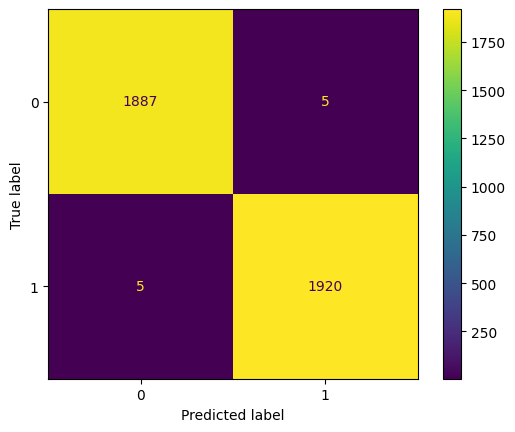

In [85]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)

# Plot confusion matrix
disp.plot()

# Display plot
plt.show()


Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

{'opinion': {'precision': 0.9973572938689218, 'recall': 0.9973572938689218, 'f1-score': 0.9973572938689218, 'support': 1892.0}, 'claim': {'precision': 0.9974025974025974, 'recall': 0.9974025974025974, 'f1-score': 0.9974025974025974, 'support': 1925.0}, 'accuracy': 0.9973801414723605, 'macro avg': {'precision': 0.9973799456357596, 'recall': 0.9973799456357596, 'f1-score': 0.9973799456357596, 'support': 3817.0}, 'weighted avg': {'precision': 0.9973801414723605, 'recall': 0.9973801414723605, 'f1-score': 0.9973801414723605, 'support': 3817.0}}


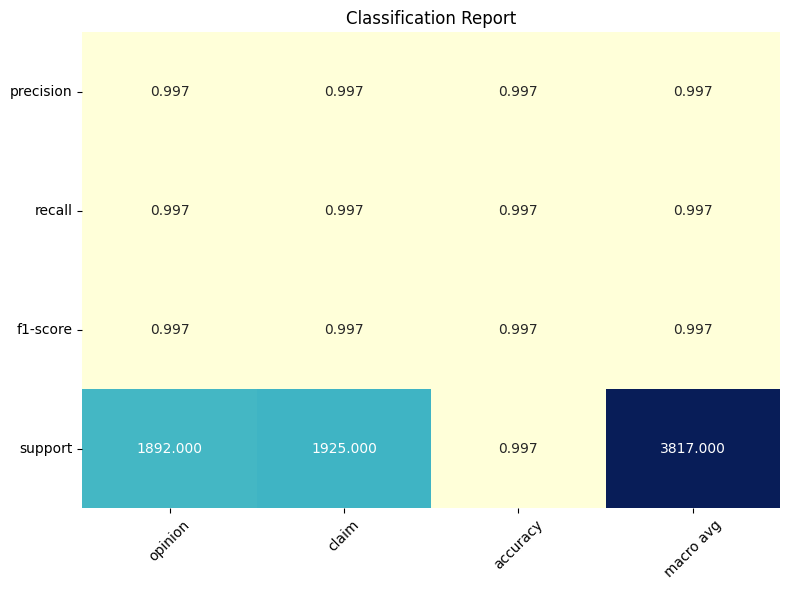

In [89]:
# Create a classification report
# Create classification report for random forest model

target_labels = ['opinion', 'claim']
report = classification_report(y_val, y_pred, target_names=target_labels, output_dict=True)
print(report)

df_temp = pd.DataFrame(data=report).transpose()

# Create a heatmap image of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(df_temp.iloc[:-1, :].T, annot=True, cmap="YlGnBu", cbar=False, fmt='.3f')

# Set labels and title
plt.title('Classification Report')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()

# Save as image
plt.savefig('Figures/classification_report.png')

# Display the image
plt.show()

The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

#### **XGBoost**

In [42]:
#Evaluate XGBoost model
y_pred = xgb_GSCV.best_estimator_.predict(X_val_final)

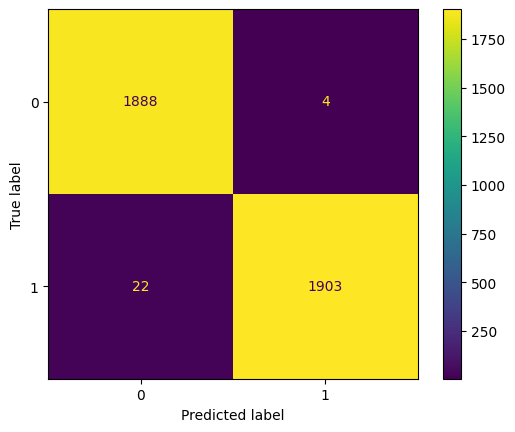

In [43]:
# Compute values for confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)

# Plot confusion matrix
disp.plot()

# Display plot
plt.show()


In [44]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### **Use champion model to predict on test data**

In [93]:
y_pred = rfc_GSCV.best_estimator_.predict(X_test_final)

{'opinion': {'precision': 0.9984447900466563, 'recall': 0.9989626556016598, 'f1-score': 0.9987036556909515, 'support': 1928.0}, 'claim': {'precision': 0.9989406779661016, 'recall': 0.9984118581259925, 'f1-score': 0.9986761980407731, 'support': 1889.0}, 'accuracy': 0.9986900707361802, 'macro avg': {'precision': 0.9986927340063789, 'recall': 0.9986872568638261, 'f1-score': 0.9986899268658623, 'support': 3817.0}, 'weighted avg': {'precision': 0.9986902006517996, 'recall': 0.9986900707361802, 'f1-score': 0.9986900671394222, 'support': 3817.0}}


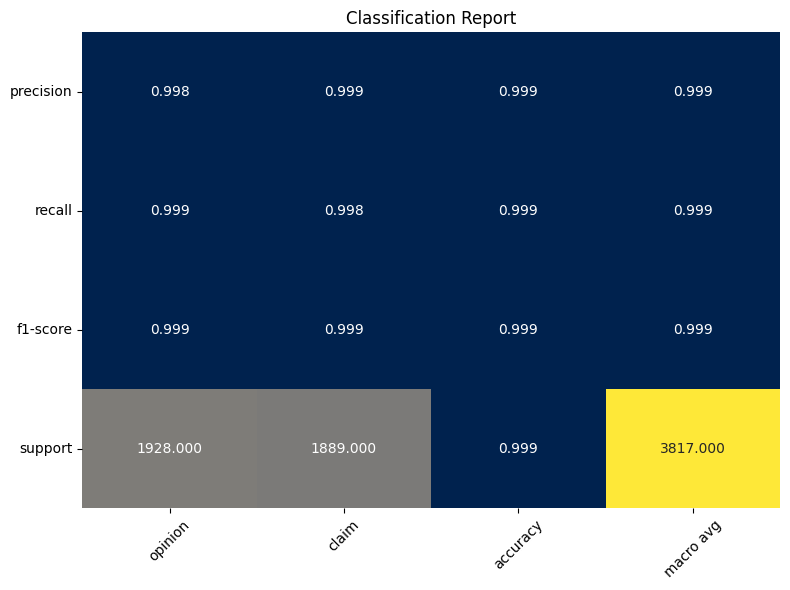

In [100]:
target_labels = ['opinion', 'claim']
report = classification_report(y_test, y_pred, target_names=target_labels, output_dict=True)
print(report)

df_temp = pd.DataFrame(data=report).transpose()

# Create a heatmap image of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(df_temp.iloc[:-1, :].T, annot=True, cmap="cividis", cbar=False, fmt='.3f')

# Set labels and title
plt.title('Classification Report')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()

# Save as image
plt.savefig('Figures/classification_report.png')

# Display the image
plt.show()

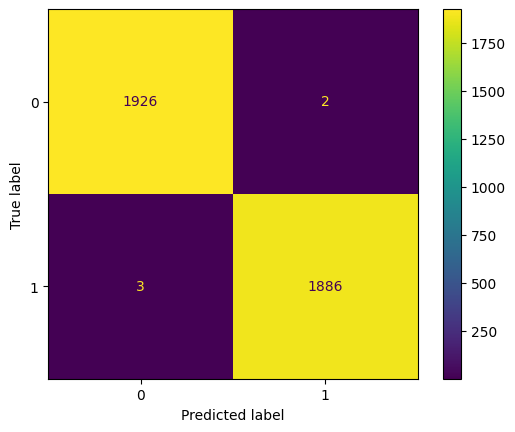

In [95]:
# Compute values for confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)

# Plot confusion matrix
disp.plot()

# Save the plot with high DPI
plt.savefig('Figures/Confusion Matrix Champion model.png', dpi=300)

# Display plot
plt.show()


#### **Feature importances of champion model**


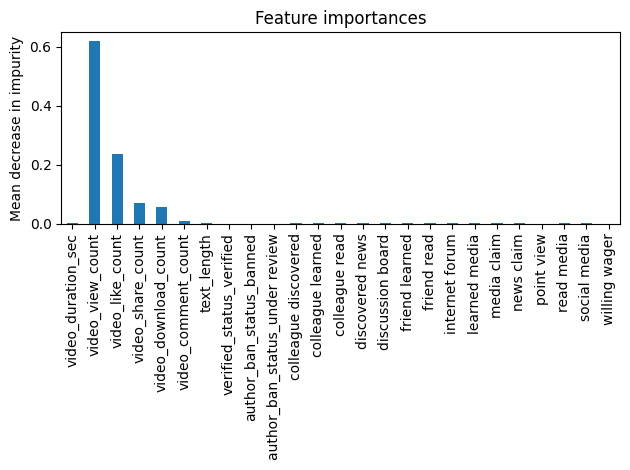

In [47]:
importances = rfc_GSCV.best_estimator_.feature_importances_
rfc_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rfc_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()



In [45]:
explainer = shap.Explainer(rfc_GSCV.best_estimator_,X_train_final)
shap_values = explainer(X_test_final)


100%|===================| 7599/7634 [00:43<00:00]        

In [46]:
print(shap_values.shape)
print(X_train_final.shape)
print(X_test_final.shape)
print(type(shap_values))
X_test_final.info()

(3817, 25, 2)
(11450, 25)
(3817, 25)
<class 'shap._explanation.Explanation'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   video_duration_sec              3817 non-null   int64  
 1   video_view_count                3817 non-null   float64
 2   video_like_count                3817 non-null   float64
 3   video_share_count               3817 non-null   float64
 4   video_download_count            3817 non-null   float64
 5   video_comment_count             3817 non-null   float64
 6   text_length                     3817 non-null   int64  
 7   verified_status_verified        3817 non-null   int64  
 8   author_ban_status_banned        3817 non-null   int64  
 9   author_ban_status_under review  3817 non-null   int64  
 10  colleague discovered            3817 non-null   int64  
 11  colleague learned 

In [50]:
show=False
shap.summary_plot(shap_values.values[:,:,1], X_test_final, show=show, max_display=10)
# shap.plots.beeswarm(shap_values[:,:,1], show=show)
if show == False:
    plt.savefig('Figures/Feature summary.png', format='png', dpi=300)
    plt.close()
shap.dependence_plot("video_view_count", shap_values.values[:,:,1], X_test_final, show=show)
if show == False:
    plt.savefig('Figures/Feature Dependence.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()
shap.plots.waterfall(shap_values[0,:,1], show=show)
if show == False:
    plt.savefig('Figures/Feature Waterfall.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()


The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

### **Task 8. Conclusion**

1. *Would you recommend using this model? Why or why not?*
Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>
2. *What was your model doing? Can you explain how it was making predictions?*
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>
3. *Are there new features that you can engineer that might improve model performance?*
Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>
4. *What features would you want to have that would likely improve the performance of your model?*
The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.